# Read checkerboard model and plot velocity and azimuthal anisotropy in horizontal section

In [25]:
from pytomoatt.model import ATTModel
import numpy as np
# initial model hdf5 file
init_model_file = '2_models/model_init_N7_201_201.h5'
# checkerboard model hdf5 file
ckb_model_file = '2_models/model_ckb_N7_201_201.h5'
# input parameters file
par_file = '3_input_params/input_params_inv.yaml'

# read model file by pytomoatt
model = ATTModel.read(init_model_file, par_file)
init_model = model.to_xarray()

model = ATTModel.read(ckb_model_file, par_file)
ckb_model = model.to_xarray()



# we can access the velocity at arbitrary depth
depth = 0.0
tmp = ckb_model.interp_dep(depth, field='vel')
longitude = tmp[:,0]
latitude = tmp[:,1]
vel_ckb = tmp[:,2]
vel_init = init_model.interp_dep(depth, field='vel')[:,2]
vel_pert = (vel_ckb - vel_init)/vel_init * 100.0

# similarly, anisotropic parameters xi and eta
xi_ckb  = ckb_model.interp_dep(depth, field='xi')[:,2]
eta_ckb = ckb_model.interp_dep(depth, field='eta')[:,2]

# magnitude and direction of anisotropy
tmp     = ckb_model.interp_dep(depth, field='phi', samp_interval=20) # fast velocity direction, samp_interval is the sampling one point every 20 points in each axis
ani_lon = tmp[:,0]
ani_lat = tmp[:,1]
ani_phi = tmp[:,2]
ani_epsilon = ckb_model.interp_dep(depth, field='epsilon', samp_interval=20)[:,2]

epsilon = ckb_model.interp_dep(depth, field='epsilon')[:,2]

# Pygmt plot velocity perturbation related to initial model, xi, eta, fast velocity directions

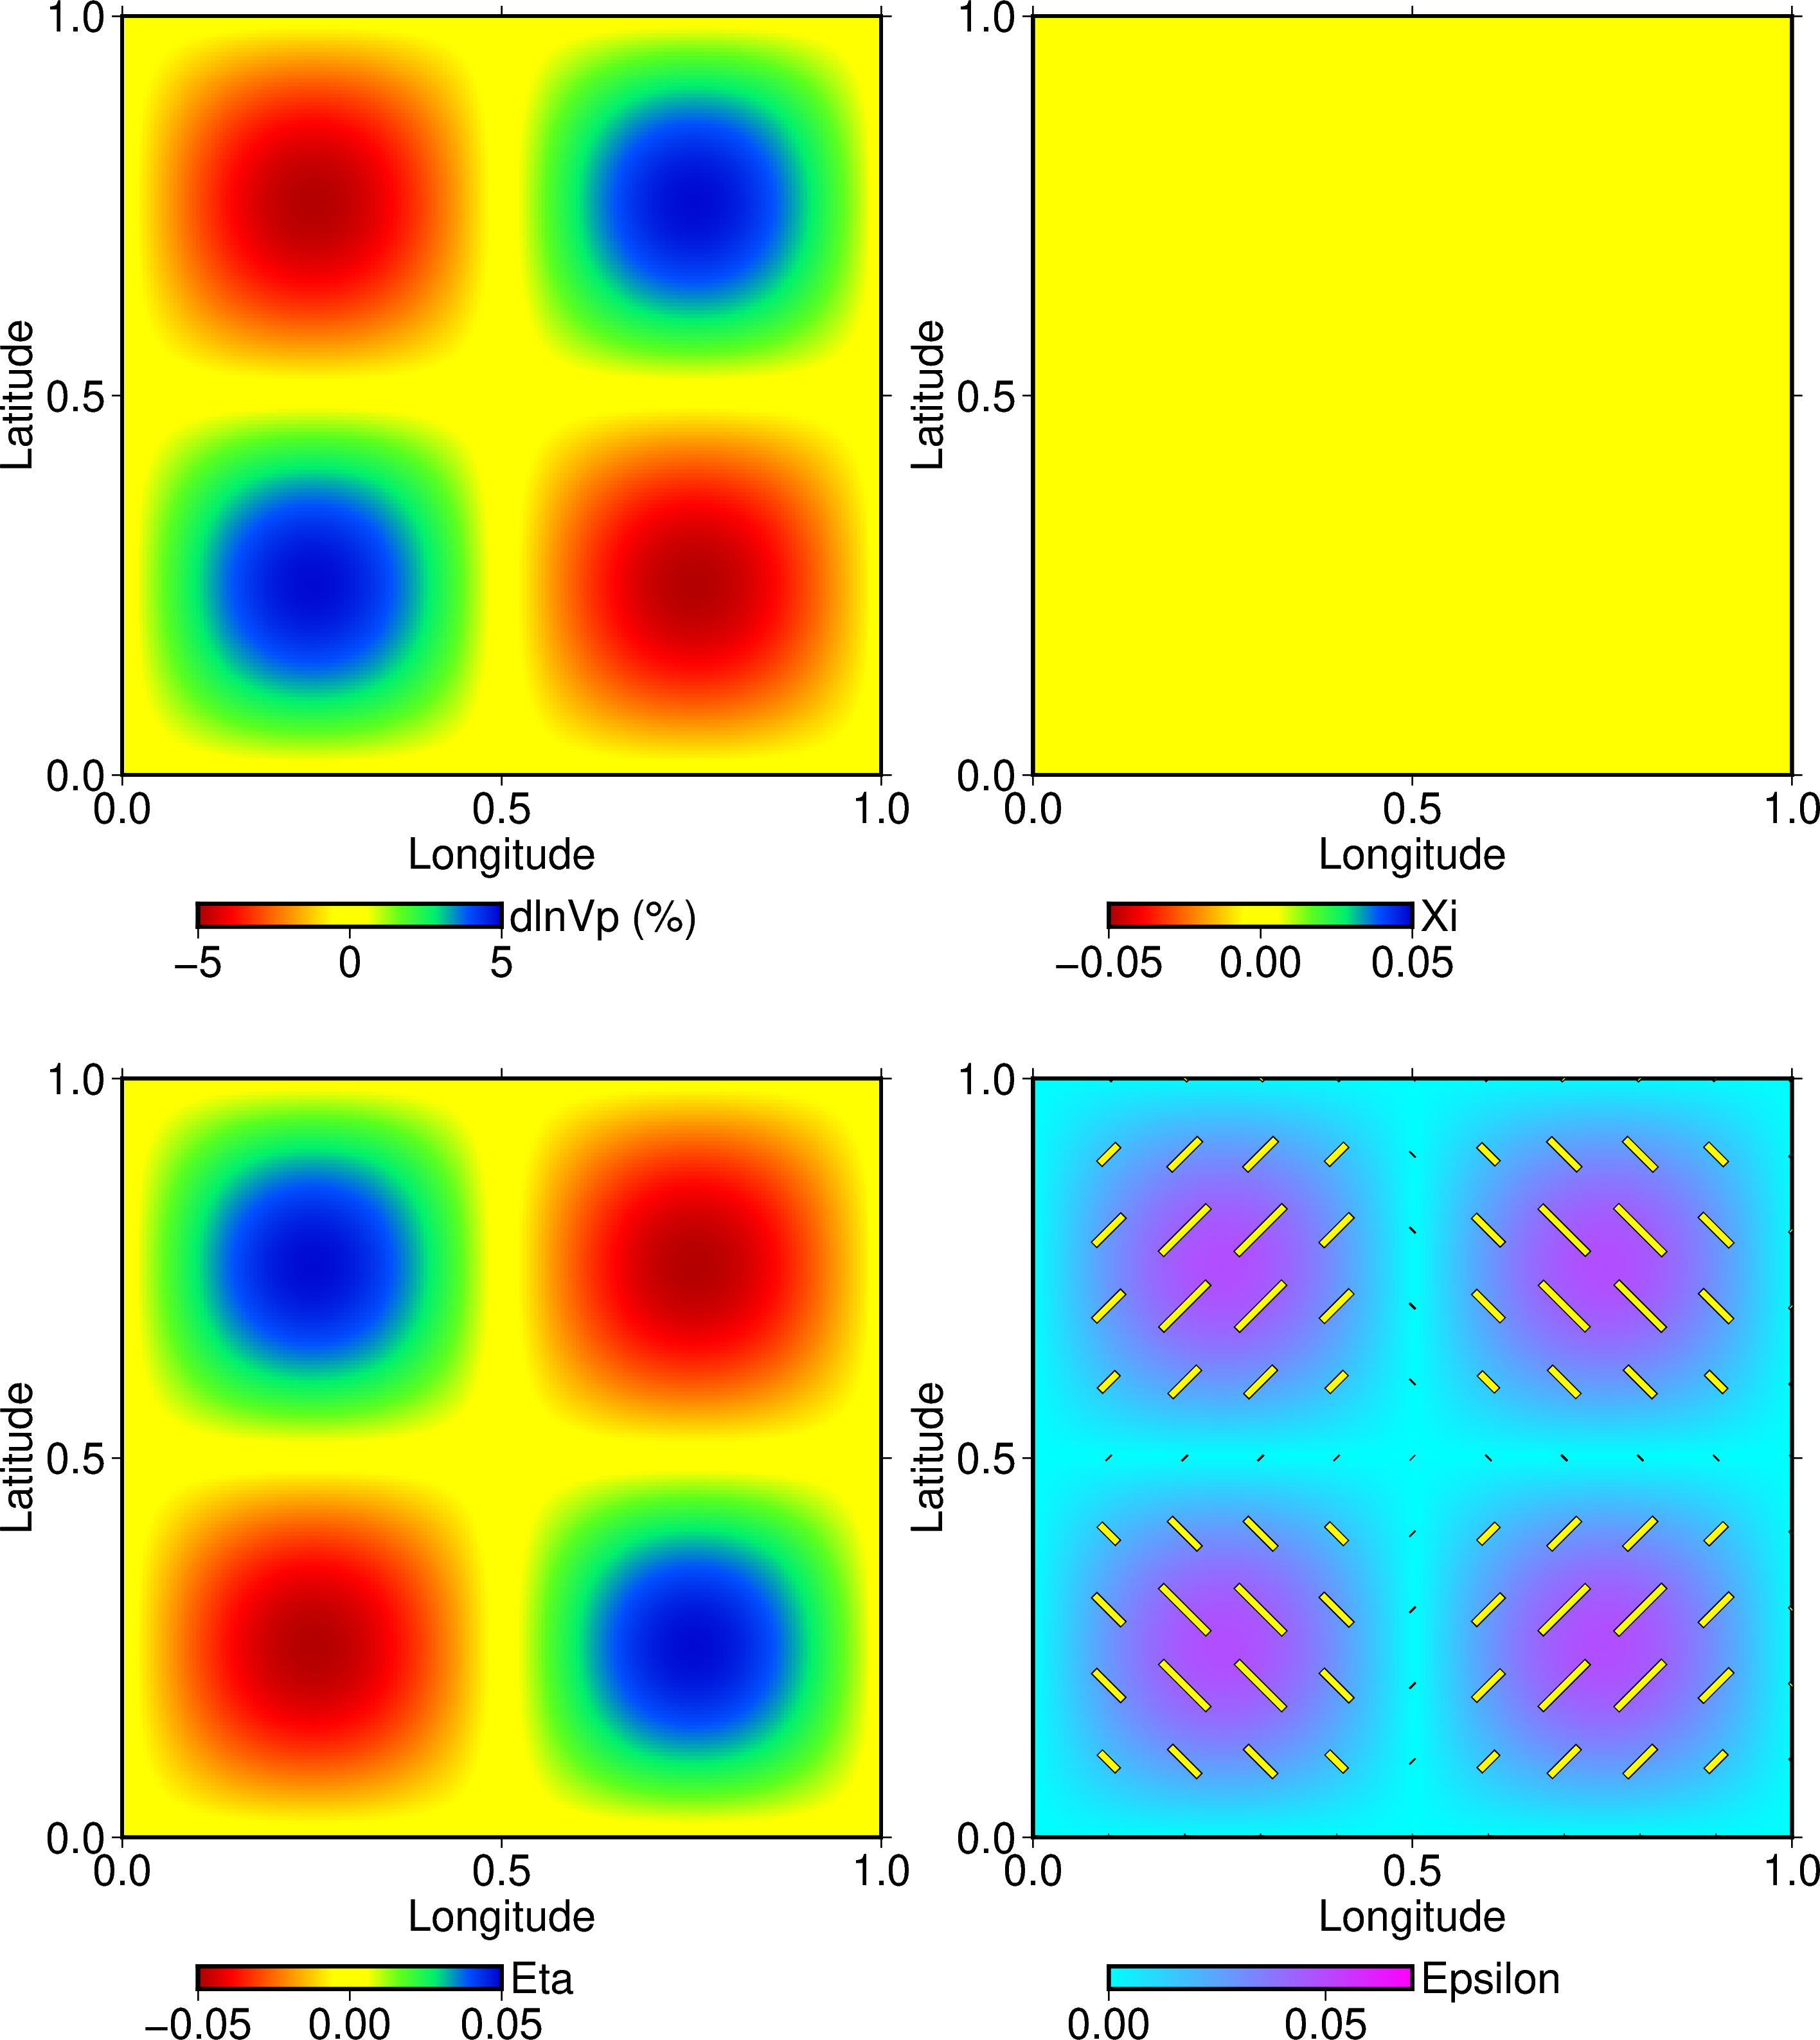

In [29]:
# pygmt plot
import pygmt
from pygmt.clib import Session
with pygmt.clib.Session() as session:
    session.call_module('gmtset', 'FONT 16p')
pygmt.config(IO_SEGMENT_MARKER="<<<")

region = [0,1,0,1]
projection = "X10c/10c"
frame = ["xa0.5+lLongitude", "ya0.5+lLatitude", "nSWe"]

fig = pygmt.Figure()

# ----------- plot velocity model ------------
pygmt.makecpt(cmap="seis", series=[-5, 5], background=True, reverse=False)
grid = pygmt.xyz2grd(x=longitude, y=latitude, z=vel_pert, spacing=0.005,region=region,)
fig.grdimage(frame=frame,grid = grid,projection=projection, region=region) # nan_transparent may work

fig.shift_origin(xshift= 1, yshift=-2)
fig.colorbar(frame = ["a%f"%(5),"y+ldlnVp (%)"], position="+w4c/0.3c+h") # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平
fig.shift_origin(xshift=-1, yshift=+2)

# ----------- plot xi model ------------
fig.shift_origin(xshift= 12)
pygmt.makecpt(cmap="seis", series=[-0.05, 0.05], background=True, reverse=False)
grid = pygmt.xyz2grd(x=longitude, y=latitude, z=xi_ckb, spacing=0.005,region=region,)
fig.grdimage(frame=frame,grid = grid,projection=projection, region=region) # nan_transparent may work

fig.shift_origin(xshift= 1, yshift=-2)
fig.colorbar(frame = ["a%f"%(0.05),"y+lXi"], position="+w4c/0.3c+h") # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平
fig.shift_origin(xshift=-1, yshift=+2)

# ----------- plot eta model ------------
fig.shift_origin(xshift= -12, yshift=-14)
pygmt.makecpt(cmap="seis", series=[-0.05, 0.05], background=True, reverse=False)
grid = pygmt.xyz2grd(x=longitude, y=latitude, z=eta_ckb, spacing=0.005,region=region,)
fig.grdimage(frame=frame,grid = grid,projection=projection, region=region) # nan_transparent may work

fig.shift_origin(xshift= 1, yshift=-2)
fig.colorbar(frame = ["a%f"%(0.05),"y+lEta"], position="+w4c/0.3c+h") # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平
fig.shift_origin(xshift=-1, yshift=+2)

# ----------- plot fast velocity direction ------------
fig.shift_origin(xshift= 12)
pygmt.makecpt(cmap="cool", series=[0, 0.07], background=True)
grid = pygmt.xyz2grd(x=longitude, y=latitude, z=epsilon, spacing=0.005,region=region,)
fig.grdimage(frame=frame,grid = grid,projection=projection, region=region) # nan_transparent may work

ani = np.hstack([ani_lon[:,None], ani_lat[:,None], ani_phi[:,None], ani_epsilon[:,None]*20, np.ones((ani_phi.shape[0],1))*0.1])
fig.plot(ani, style='j', fill='yellow1', pen='0.3p,black')

fig.shift_origin(xshift= 1, yshift=-2)
fig.colorbar(frame = ["a%f"%(0.05),"y+lEpsilon"], position="+w4c/0.3c+h") # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平
fig.shift_origin(xshift=-1, yshift=+2)

fig.show()
fig.savefig('img/2a_ckb_model.png')